Nama: Musyaffa Ayman Rafif

NIM: 2502004102

# Setup Notebook

In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
print(len(tf.config.list_physical_devices('GPU')))

1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec 
from keras.preprocessing.text import one_hot,Tokenizer
from keras.utils import pad_sequences


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from keras.initializers import Constant
from tensorflow.keras.layers import Dense, Embedding, Activation, Flatten


In [4]:
def cleansing(df):
    df_clean=df.str.lower()
    df_clean=[re.sub(r"\d+","",i )for i in df_clean]
    df_clean=[re.sub(r'[^\w]', ' ', i)for i in df_clean]
    df_clean=[re.sub(r'\s+',' ',i)for i in df_clean]
    return df_clean

In [5]:
df = pd.read_csv('train_data.csv')

# Data Preprocessing

In [6]:
df.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16990 non-null  object
 1   label   16990 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 265.6+ KB


In [8]:
df['label'].value_counts().sort_index()

label
0      255
1      837
2     3545
3      321
4      359
5      987
6      524
7      624
8      166
9     1557
10      69
11      44
12     487
13     471
14    1822
15     501
16     985
17     495
18    2118
19     823
Name: count, dtype: int64

In [9]:
df['clean_text']=cleansing(df['text'])

In [10]:
df.sample(5)

,text,label,clean_text
2947,"UKRAINE SAYS IT HAS RECEIVED ""EXPLICIT INDICAT...",2,ukraine says it has received explicit indicati...
5786,European natural gas prices fall after Russia ...,6,european natural gas prices fall after russia ...
16602,$IBM - IBM Falls As Guidance Cut. https://t.c...,19,ibm ibm falls as guidance cut https t co xcvq...
13233,President Biden could declare a climate emerge...,16,president biden could declare a climate emerge...
3450,Day two of the Farnborough International Airsh...,2,day two of the farnborough international airsh...


In [11]:
# Check maximum len(word) in a sentence
max_sen = df['clean_text'].str.split().str.len().max()
print(max_sen)

58


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size = 0.2, random_state = 5,stratify=df['label'])

In [13]:
print("Total Size: ", len(df))
print("Train Size: ", len(X_train))
print("Test Size: ", len(X_test))

Total Size:  16990
Train Size:  13592
Test Size:  3398


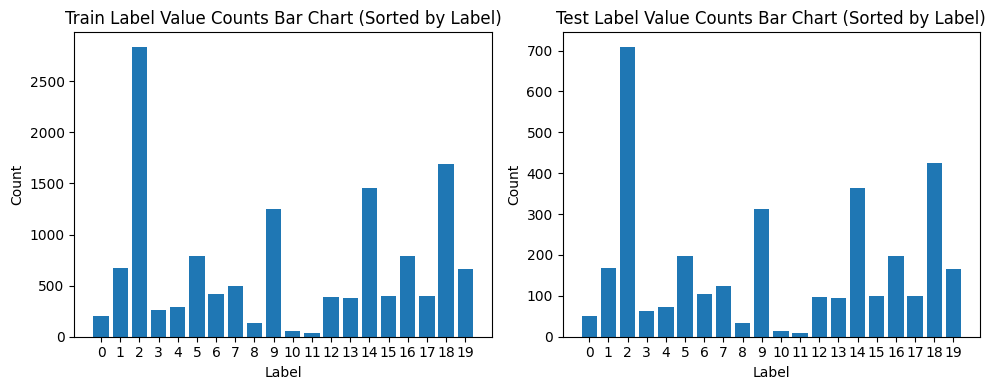

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

label_train_count = y_train.value_counts().sort_index()
axes[0].bar(label_train_count.index.astype(str), label_train_count.values)
axes[0].set_title('Train Label Value Counts Bar Chart (Sorted by Label)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

label_test_count = y_test.value_counts().sort_index()
axes[1].bar(label_test_count.index.astype(str), label_test_count.values)
axes[1].set_title('Test Label Value Counts Bar Chart (Sorted by Label)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [15]:
word_token=[word_tokenize(i) for i in X_train]
model_skipgram = gensim.models.Word2Vec(word_token, min_count = 1,vector_size = 100, window = 5, sg=1) 
model_skipgram.train(word_token,epochs=10,total_examples=len(word_token))

(2223439, 2903200)

In [16]:
vocabulary_skipgram = model_skipgram.wv.index_to_key
len(vocabulary_skipgram)

34590

In [17]:
word_vec_dict={}
for word in vocabulary_skipgram:
    word_vec_dict[word]=model_skipgram.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  34590


In [18]:
tok = Tokenizer()
tok.fit_on_texts(X_train)
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(X_train)

In [19]:
max_sen_len= max_sen # max lenght of word in a sentence
vocab_size = len(tok.word_index) + 1 #ideally it should be len(tok.word_index) + 1  or total no of words in data in this case = 337, but to handle number of data which not appear in train, for example in test, make the size higher
embed_dim=100 # embedding dimension as choosen in word2vec constructor

In [20]:
pad_rev= pad_sequences(encd_rev, maxlen=max_sen_len, padding='post')
pad_rev.shape   

(13592, 58)

In [21]:
# now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
    embed_vector=word_vec_dict.get(word) #mapping the vector to word in our skipgram dictionary
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

# Modeling

In [22]:
model = keras.Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_sen_len,embeddings_initializer=Constant(embed_matrix)))
model.add(layers.LSTM(64, input_shape=(None, 28)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 100)           3458100   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 3,501,246
Trainable params: 3,501,118
Non-trainable params: 128
_________________________________________________________________
None


In [23]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)

In [24]:
model.fit(pad_rev, y_train, batch_size=2, epochs=2)

Epoch 1/2
6796/6796 [==============================] - 88s 12ms/step - loss: nan - accuracy: 0.0150
Epoch 2/2
6796/6796 [==============================] - 81s 12ms/step - loss: nan - accuracy: 0.0150


# Tuned Model

In [25]:
from keras import backend
from keras.optimizers import Adam
from keras.layers import Dropout

In [31]:
backend.clear_session()

tuned_model = keras.Sequential()
tuned_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_sen_len,embeddings_initializer=Constant(embed_matrix)))
tuned_model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
tuned_model.add(layers.BatchNormalization())
tuned_model.add(Dropout(0.5))
tuned_model.add(layers.Dense(20, activation='softmax')) # Sesuain sama jumlah output label/class nya
print(tuned_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 100)           3458100   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 3,501,896
Trainable params: 3,501,768
Non-trainable params: 128
____________________________________________

In [32]:
tuned_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="sgd",  # Adjust the learning rate
    metrics=["accuracy"]
)

In [33]:
tuned_model.fit(pad_rev, y_train, batch_size=2, epochs=1) # Epoch nya saya ubah jadi 1 karena per epoch estimated 30 menit :(

6796/6796 [==============================] - 1509s 222ms/step - loss: 2.6509 - accuracy: 0.2029
